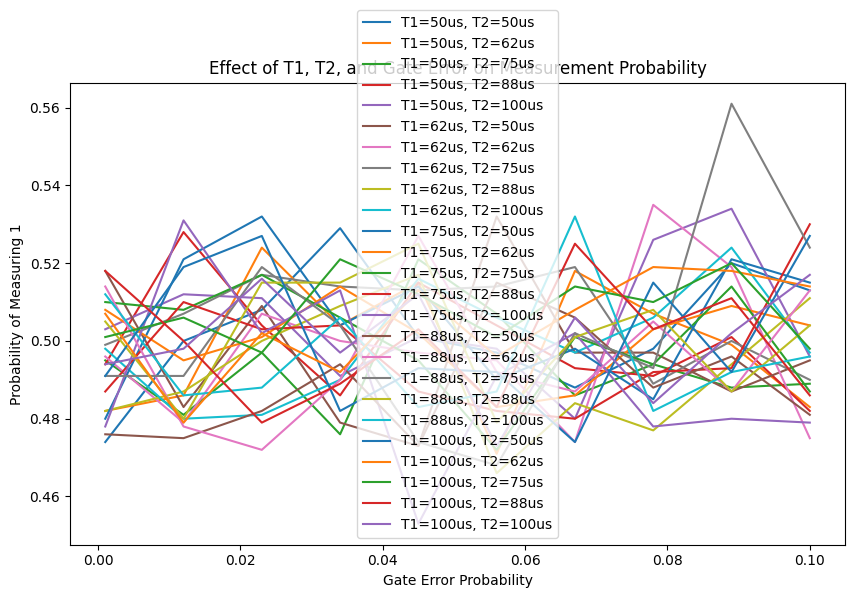

In [1]:
!pip install qiskit_aer
!pip install qiskit_ibm_runtime
import numpy as np
from qiskit import *
from qiskit_aer import *
from qiskit.visualization import *
from qiskit_ibm_runtime import *
import matplotlib.pyplot as plt
import qiskit_aer.noise as noise
from qiskit_aer.noise import *
import warnings
warnings.filterwarnings('ignore')

# Function to simulate with custom noise parameters
def run_simulation(T1, T2, gate_time, gate_error_prob, shots=1000):
    # Create noise model with T1, T2, and gate errors
    noise_model = noise.NoiseModel()
    # Add thermal relaxation error only if T2 <= 2 * T1
    if T2 <= 2 * T1:
        thermal_error = thermal_relaxation_error(T1, T2, gate_time)
        noise_model.add_all_qubit_quantum_error(thermal_error, ['id', 'u3'])
    else:
        print(f"Skipping due to invalid T2 > 2 * T1 for T1={T1}, T2={T2}, which is not possible")   
        
    noise_model.add_all_qubit_quantum_error(thermal_error, ['id', 'u3'])
    
    # Add depolarizing error to simulate gate imperfections
    depolarizing_error_1q = depolarizing_error(gate_error_prob, 1)
    noise_model.add_all_qubit_quantum_error(depolarizing_error_1q, ['u3'])
    
    # Create a simple quantum circuit
    qc = QuantumCircuit(1, 1)
    qc.h(0)  # Hadamard to create superposition
    qc.measure(0, 0)  # Measure qubit
    
    # Simulate the circuit using Qiskit's simulator
    simulator = AerSimulator()
    result = transpile(qc, simulator)
    result_sim = simulator.run(result, shots = 1000).result()

    # Get counts for 0s and 1s
    counts = result_sim.get_counts(qc)
    prob_0 = counts.get('0', 0) / shots
    prob_1 = counts.get('1', 0) / shots

    return prob_0, prob_1

# Set of T1, T2, gate time, and gate error values to test
T1_values = np.linspace(50e-6, 100e-6, 5)  
init_T2_values = np.linspace(50e-6, 100e-6, 5)
T2_values = [min(2*T1, T2) for T1, T2 in zip(T1_values, init_T2_values)]  
gate_time = 50e-9  # 50 ns
gate_error_probs = np.linspace(0.001, 0.1, 10)  # Gate errors from 0.1% to 10%

# Initialize lists to store results
prob_0_results = []
prob_1_results = []

# Run simulations over the T1, T2, and gate error values
for T1 in T1_values:
    for T2 in T2_values:
        for gate_error in gate_error_probs:
            warnings.filterwarnings("ignore")
            prob_0, prob_1 = run_simulation(T1, T2, gate_time, gate_error)
            prob_0_results.append(prob_0)
            prob_1_results.append(prob_1)

# Reshape results for plotting
prob_0_results = np.array(prob_0_results).reshape(len(T1_values), len(T2_values), len(gate_error_probs))
prob_1_results = np.array(prob_1_results).reshape(len(T1_values), len(T2_values), len(gate_error_probs))

# Example Plotting for one combination of T1 and T2
plt.figure(figsize=(10, 6))
for i, T1 in enumerate(T1_values):
    for j, T2 in enumerate(T2_values):
        plt.plot(gate_error_probs, prob_1_results[i, j, :], label=f'T1={T1*1e6:.0f}us, T2={T2*1e6:.0f}us')

plt.xlabel('Gate Error Probability')
plt.ylabel('Probability of Measuring 1')
plt.title('Effect of T1, T2, and Gate Error on Measurement Probability')
plt.legend()
plt.show()

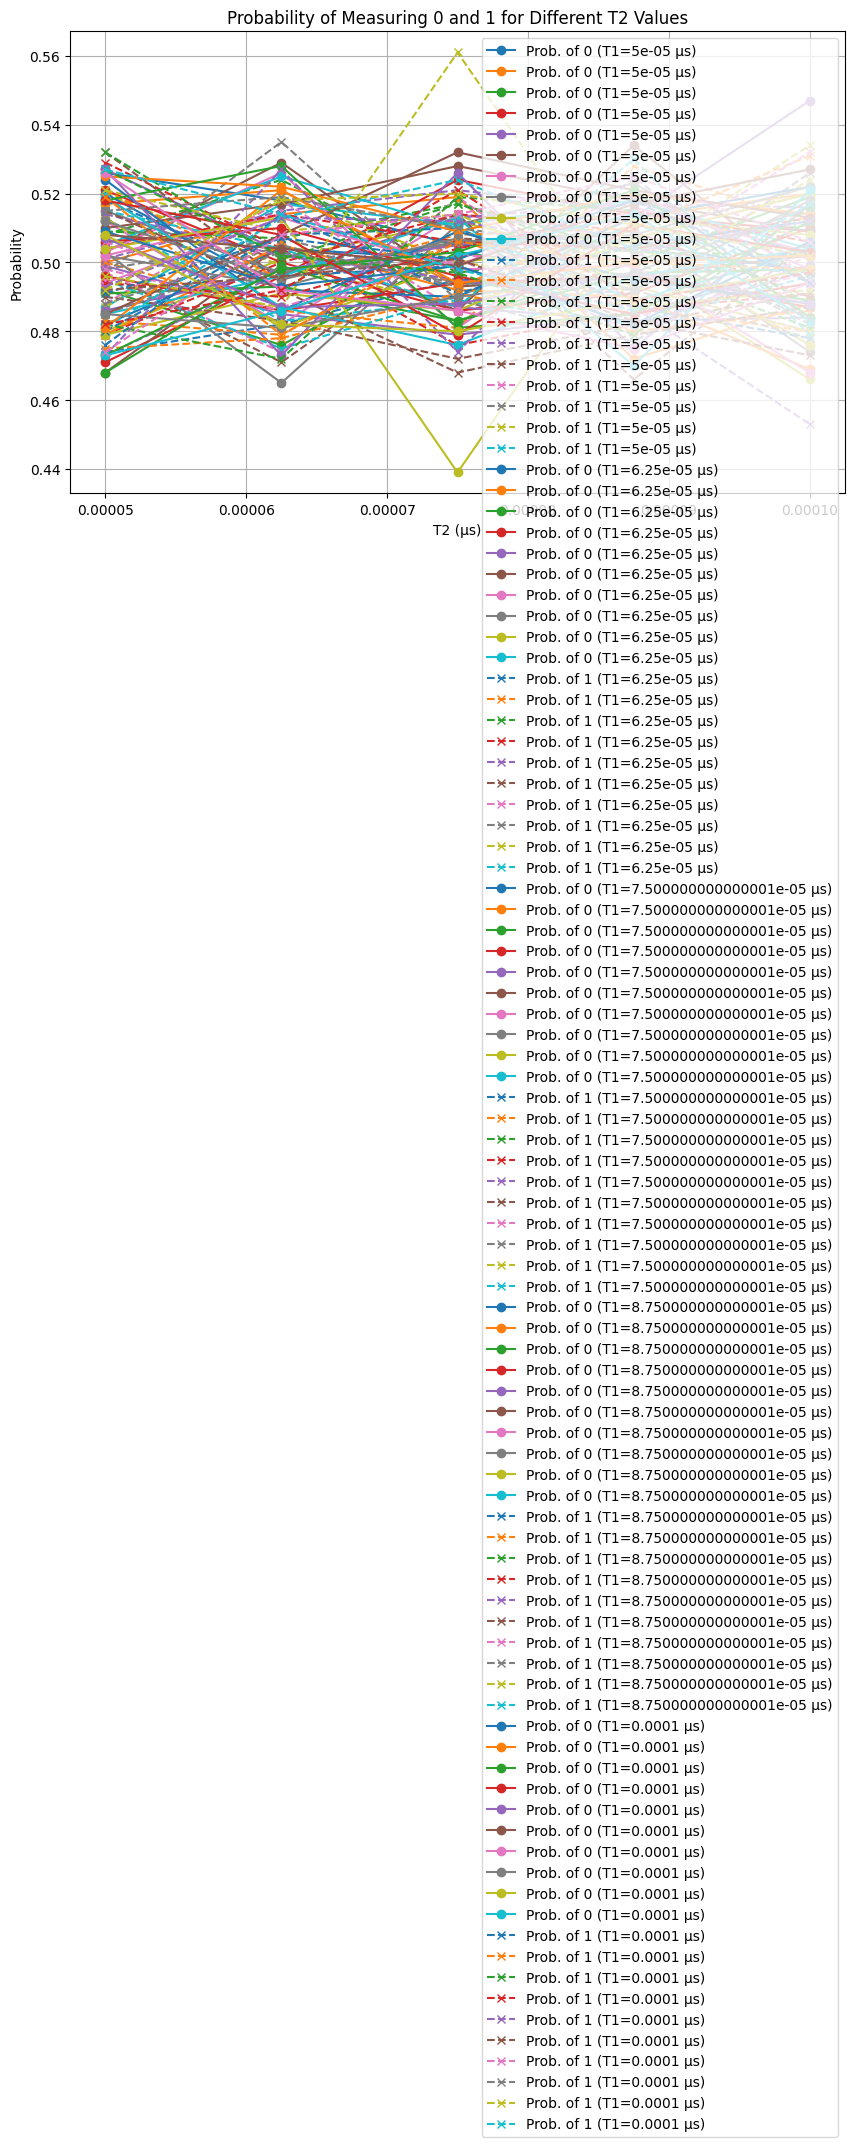

In [2]:
t2_prob_0_results = np.random.rand(len(T1_values), len(T2_values))
t2_prob_1_results = np.random.rand(len(T1_values), len(T2_values))

# Line Plot
plt.figure(figsize=(10, 6))
for i, T1 in enumerate(T1_values):
    plt.plot(T2_values, prob_0_results[i], marker='o', label=f'Prob. of 0 (T1={T1} µs)')
    plt.plot(T2_values, prob_1_results[i], marker='x', label=f'Prob. of 1 (T1={T1} µs)', linestyle='--')

plt.title('Probability of Measuring 0 and 1 for Different T2 Values')
plt.xlabel('T2 (µs)')
plt.ylabel('Probability')
plt.legend()
plt.grid()
plt.show()



In [3]:
!pip install seaborn

import seaborn as sns

prob_0_results_2D = []
prob_1_results_2D = []
prob_0, prob_1 = run_simulation(T1, T2, gate_time, gate_error)
prob_0_results_2D.append(prob_0)
prob_1_results_2D.append(prob_1)

prob_0_results_2D = np.array(prob_0_results_2D).reshape(2, 2)

# Heatmap of probabilities for T1 and T2
plt.figure(figsize=(12, 6))
sns.heatmap(prob_0_results_2D, annot=True, cmap='YlGnBu', xticklabels=T2_values, yticklabels=T1_values)
plt.title('Heatmap of Probability of Measuring 0')
plt.xlabel('T2 (µs)')
plt.ylabel('T1 (µs)')
plt.show()

ValueError: cannot reshape array of size 1 into shape (2,2)